# A utility for the importing of patient cutouts from XiO

This utility makes use of user provided XiO access credentials along with a patient ID and then returns the cutout X and Y coords along with applicator, energy, and server filepath for each plan found for that ID on the server.

An example of using this object can be found [at the bottom of this notebook](#Example).

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Required modules

In [1]:
import spur
import numpy as np
import shutil
import re
import os

## The XiO utility object

In [2]:
class XiO_Utility(object):
    
    def __init__(self, **kwargs):
        
        self.patientID = str(kwargs['patientID'])
        
        self.hostname = kwargs['hostname']
        self.username = kwargs['username']
        self.password = kwargs['password']
        
        self.find_tel_files()
        self.sftp_tempfile_copy()
        self.parse_tel_file()
        self.remove_local_tel_files()
        
    
    def ssh_shell(self):
        return spur.SshShell(hostname=self.hostname, 
                             username=self.username, 
                             password=self.password)
    
    def find_tel_files(self):    
        shell = self.ssh_shell()
        result = shell.run(["find", "/FOCUS/rtp1/", "-regex", "^/.*"+self.patientID+".*.tel.1$"])
        self.rtp1TelFilepaths = result.output.splitlines()

        shell = self.ssh_shell()
        result = shell.run(["find", "/FOCUS/rtp2/", "-regex", "^/.*"+self.patientID+".*.tel.1$"])
        self.rtp2TelFilepaths = result.output.splitlines()

        self.XiOTelFilepaths = self.rtp1TelFilepaths + self.rtp2TelFilepaths
        
        
    def sftp_tempfile_copy(self):

        self.localTelFilepaths = [0,] * len(self.XiOTelFilepaths)

        for i in range(len(self.XiOTelFilepaths)):
            self.localTelFilepaths[i] = "tempImportedPlan_"+str(i)


        for i, filepath in enumerate(self.XiOTelFilepaths):
            shell = self.ssh_shell()
            with shell.open(filepath, "r") as remote_file:
                with open(self.localTelFilepaths[i], "w") as local_file:
                    shutil.copyfileobj(remote_file, local_file)
                    
    
    def parse_tel_file(self):
        
        self.XCoords = []
        self.YCoords = []
        self.info = []

        for i, filepath in enumerate(self.localTelFilepaths):

            with open(filepath, "r") as file:
                telFileContents = np.array(file.read().splitlines())

            electronPlanIndex = []
            electronPlanEnergy = []

            for j, item in enumerate(telFileContents):
                if re.search('.*MeVSynergy.*', item):
                    electronPlanIndex += [j]
                    electronPlanEnergy += [item]

            for j, index in enumerate(electronPlanIndex):
                cutoutCoordsSection = telFileContents[index+41::]
                cutoutCoordsStop = np.where(cutoutCoordsSection=='0')[0][0]

                cutoutCoords = cutoutCoordsSection[:cutoutCoordsStop]
                singleStringCoords = ",".join(list(cutoutCoords))
                coordAsArray = np.fromstring(singleStringCoords, dtype=float, count=-1, sep=',')

                XCoords = coordAsArray[0::2]/10
                YCoords = coordAsArray[1::2]/10

                applicator = float(telFileContents[index+7].split('x')[0])/10
                appString = "%dcm Applicator" %(applicator,)

                collatedInfo = np.concatenate([[self.XiOTelFilepaths[i]],
                                               [electronPlanEnergy[j]],
                                               [appString]])

                self.XCoords += [XCoords]
                self.YCoords += [YCoords]
                self.info += [collatedInfo]
                
    def remove_local_tel_files(self):
        for filepath in self.localTelFilepaths:
            os.remove(filepath)

## Execute no further if being imported

Don't want to waste time running the example if this notebook is just being imported. The following cell triggers the notebook import to stop.

In [1]:
'stop nbimport'

'stop nbimport'

## Example

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

In [4]:
credentials = pd.read_csv("../../../user_input/XiO_Credentials.csv")

hostname = credentials['hostname'].values[0]
username = credentials['username'].values[0]
password = credentials['password'].values[0]

In [5]:
patientID = 'censored'

example = XiO_Utility(patientID=patientID,
                      hostname=hostname,
                      username=username,
                      password=password)

In [8]:
example.info[0][1::]

array(['06MeVSynergyV1', '6cm Applicator'], 
      dtype='<U41')

(-3.0, 3.0, -2.5, 2.0)

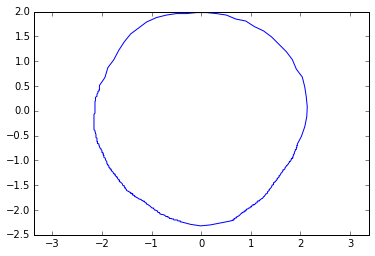

In [7]:
plt.plot(example.XCoords[0], example.YCoords[0])
plt.axis("equal")